In [7]:
using Plots, Statistics
theme(:dark)

In [8]:
# Define the Euclidean distance formula as a function
function euclidean_distance(p1, p2)
    return sqrt(sum([(p1[i] - p2[i])^2 for i = 1:length(p1)]))
end

euclidean_distance (generic function with 1 method)

In [9]:
# Create artificial data
cluster1 = [p for p in zip(rand(1:50, 50), rand(1:70, 50))]
cluster2 = [p for p in zip(rand(45:70, 50), rand(45:80, 50))]
X = [x for x in cluster1]
for x in cluster2
    push!(X, x)
end

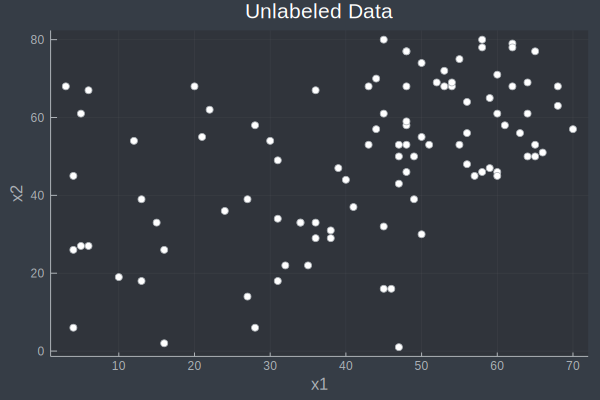

In [10]:
# Look at the unlabeled data!
scatter(X, 
        title = "Unlabeled Data",
        legend = false,
        xaxis = "x1",
        yaxis = "x2",
        color = "white")

In [15]:
function k_Means_Assignment(X, centers, k)
    distances = []
    for p in X
        temp_distances = [(j, euclidean_distance(p, centers[j])) for j = 1:length(centers)]
        sort!(temp_distances, by = x -> x[2])
        push!(distances, (p, temp_distances[1][1], temp_distances[1][2]))
    end
    new_centers = copy(centers)
    for j = 1:k
        new_centers[j] = (mean([x[1][1] for x in distances if x[2] == j]), 
                            mean([x[1][2] for x in distances if x[2] == j]))
    end
    
    return new_centers
end
                                        
function k_Means_Clustering(X, k, ϵ)
    centers = [(rand(0.0:70.0), rand(0.0:80.0)) for _ = 1:k]
    new_centers = k_Means_Assignment(X, centers, k)
    while maximum([euclidean_distance(centers[i], new_centers[i]) for i = 1:k]) > ϵ
        centers, new_centers = new_centers, k_Means_Assignment(X, new_centers, k)
    end
    return new_centers
end

k_Means_Clustering (generic function with 1 method)

In [16]:
Centers = k_Means_Clustering(X, 2, 0.05)

2-element Array{Tuple{Float64,Float64},1}:
 (25.025, 32.325)          
 (53.583333333333336, 60.8)

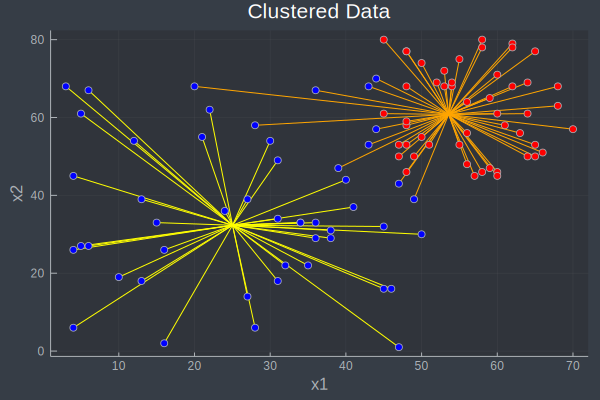

In [22]:
plot(title = "Clustered Data",
     legend = false,
     xaxis = "x1",
     yaxis = "x2", 
    label = false)
for p in X
    temp_distances = [(j, euclidean_distance(p, Centers[j])) for j = 1:2]
    sort!(temp_distances, by = x -> x[2])
    if temp_distances[1][1] == 1
        lcolor = "yellow"
    elseif temp_distances[1][1] == 2
        lcolor = "orange"
    elseif temp_distances[1][1] == 3
        lcolor = "lightblue"
    else
        lcolor = "red"
    end
    plot!([p, Centers[temp_distances[1][1]]], 
           color = lcolor)
end
scatter!(cluster1, color = "blue", label = "Class 1")
scatter!(cluster2, color = "red", label = "Class 2")

In [ ]:
plot(title = "Clustered Data",
     legend = false,
     xaxis = "x",
     yaxis = "y")
for p in X
    temp_distances = [(j, distance(p, Centers[j])) for j = 1:2]
    sort!(temp_distances, by = x -> x[2])
    if temp_distances[1][1] == 1
        scatter!(p, color = "yellow")
    elseif temp_distances[1][1] == 2
        scatter!(p, color = "orange")
    elseif temp_distances[1][1] == 3
        scatter!(p, color = "lightblue")
    else
        scatter!(p, color = "red")
    end
end
scatter!()

In [ ]:
using CSV

In [ ]:
data = CSV.read("buddymove_holidayiq.csv")

In [ ]:
data[1:end,2:end]

In [1]:
pwd()

"/Users/randydavila/Documents/Teaching/Teaching/UHD_DATA/DATA_4319/K_Means_Clustering"